**Import Dependcies**

In [ ]:
#libraries for data cleaning and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#library for train test data split and Sacaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#library for balancing the data
from imblearn.combine import SMOTEENN

#libraries for Model Building
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# **DATA CLEANING**

**Data Importing**

In [ ]:
cus_df = pd.read_csv("/content/train.csv")

**Understanding the Data**

In [ ]:
cus_df.head()#print first five columns

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no


In [ ]:
#checking the data type and number of columns
cus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45211 non-null  int64 
 1   job             45211 non-null  object
 2   marital         45211 non-null  object
 3   education_qual  45211 non-null  object
 4   call_type       45211 non-null  object
 5   day             45211 non-null  int64 
 6   mon             45211 non-null  object
 7   dur             45211 non-null  int64 
 8   num_calls       45211 non-null  int64 
 9   prev_outcome    45211 non-null  object
 10  y               45211 non-null  object
dtypes: int64(4), object(7)
memory usage: 3.8+ MB


In [ ]:
print("Number of Rows in the dataset: ",cus_df.shape[0])
print("Number of Rows in the dataset: ",cus_df.shape[1])

Number of Rows in the dataset:  45211
Number of Rows in the dataset:  11


In [ ]:
#statistical Information about numerical columns
cus_df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [ ]:
#categorical columns
cus_df_cat = cus_df.select_dtypes(include = object)
cus_df_cat = cus_df_cat.columns.tolist()
print('categorical columns: ',cus_df_cat)

#Numerical columns
cus_df_num = cus_df.select_dtypes(exclude = object)
cus_df_num = cus_df_num.columns.tolist()
print('Numcerical columns: ',cus_df_num)


categorical columns:  ['job', 'marital', 'education_qual', 'call_type', 'mon', 'prev_outcome', 'y']
Numcerical columns:  ['age', 'day', 'dur', 'num_calls']


In [ ]:
#unique values in categorical columns
for i in cus_df_cat:
  print(f'{i}'+ ":",cus_df[i].unique(),'\n')

job: ['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student'] 

marital: ['married' 'single' 'divorced'] 

education_qual: ['tertiary' 'secondary' 'unknown' 'primary'] 

call_type: ['unknown' 'cellular' 'telephone'] 

mon: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

prev_outcome: ['unknown' 'failure' 'other' 'success'] 

y: ['no' 'yes'] 



In [ ]:
#number of duplicates in data
cus_df.duplicated().sum()

6

In [ ]:
#we have only 6 duplicates so decided to drop the duplicates
cus_df = cus_df.drop_duplicates()
print("Now the dataset has {} rows and {} columns after dropping duplicates".format(cus_df.shape[0], cus_df.shape[1]))

Now the dataset has 45205 rows and 11 columns after dropping duplicates


**Target column**

In [ ]:
target_count = cus_df['y'].value_counts()
print('Class No:',  target_count[0])
print('Class yes:',  target_count[1])
print("The percentage of data where insurance is not given:", ((cus_df['y']=='no').sum()/cus_df.shape[0])*100)

Class No: 39916
Class yes: 5289
The percentage of data where insurance is not given: 88.29996681782988


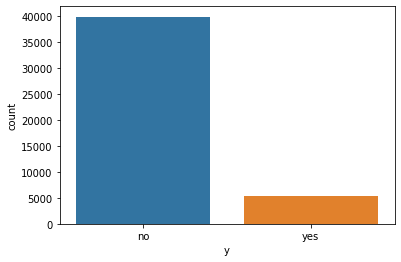

In [ ]:
sns.countplot('y',data=cus_df)
plt.show()

1. Since, more than 70% of target data is 'no', it is an imbalanced learning problem.
2. So, we will use 'Cluster-Centroid Undersampling' or 'SMOTE Oversampling'. (else. 'SMOTEEN').

In [ ]:
print("The percentage of data where insurance is not given:", ((cus_df['y']=='no').sum()/cus_df.shape[0])*100)

The percentage of data where insurance is not given: 88.29996681782988


**AGE** - Column

In [ ]:
#checking for null values
cus_df['age'].isnull().sum()

0

In [ ]:
#converting the datatype
cus_df['age'] = cus_df['age'].astype('int64')

In [ ]:
cus_df['age'] = cus_df['age'].astype(int)

Text(0.5, 1.0, 'Checking outliers')

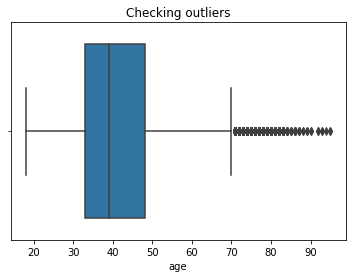

In [ ]:
#plot for checking outliers
sns.boxplot('age',data=cus_df)
plt.title("Checking outliers",)

In [ ]:
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*(IQR)
    upper_fence = Q3 + 1.5*(IQR)
    total_outliers = dataframe.loc[(dataframe[column] < lower_fence) | (dataframe[column] > upper_fence)]
    
    print("LowerFence: {}, UpperFence: {}\n{} Outliers present in {}".format(lower_fence, upper_fence, len(total_outliers), column))

In [ ]:
detect_outliers(cus_df,'age')

LowerFence: 10.5, UpperFence: 70.5
487 Outliers present in age


In [ ]:
def clip_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5*(IQR)
    upper_fence = Q3 + 1.5*(IQR)
    dataframe[column] = dataframe[column].clip(lower_fence, upper_fence)

In [ ]:
#cliping the outliers
clip_outliers(cus_df,'age')

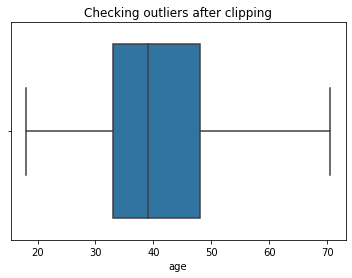

In [ ]:
#boxplot after cliping outliers
sns.boxplot(cus_df['age'])
plt.title("Checking outliers after clipping",)
plt.show()

**Job** -- column

In [ ]:
#unique values in job column
cus_df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [ ]:
#No. of rows have unknown values
(cus_df['job']=='unknown').sum()

288

In [ ]:
print("The percentage of unknown data is:", ((cus_df['job']=='unknown').sum()/cus_df.shape[0])*100)

The percentage of unknown data is: 0.6370976661873686


Only 0.6% of data is unknown in the job feature is unknown, so i decided to drop the unknown values in the feature

In [ ]:
cus_df = cus_df.drop(cus_df[cus_df['job']=='unknown'].index).reset_index(drop=True)

In [ ]:
print("Now the dataset has {} rows and {} columns after dropping unknown values in job".format(cus_df.shape[0], cus_df.shape[1]))

Now the dataset has 44917 rows and 11 columns after dropping unknown values in job


In [ ]:
#Spelling Correction
cus_df['job'].replace("admin.","admin",inplace=True)

In [ ]:
#value count for each type of job
cus_df['job'].value_counts()

blue-collar      9730
management       9457
technician       7596
admin            5170
services         4153
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
Name: job, dtype: int64

In [ ]:
cus_df['target'] = cus_df['y'].map({"yes":1,"no":0})

In [ ]:
cus_df.groupby('job')['target'].mean()

job
admin            0.122050
blue-collar      0.072765
entrepreneur     0.082717
housemaid        0.087903
management       0.137570
retired          0.227915
self-employed    0.118429
services         0.088851
student          0.286780
technician       0.110585
unemployed       0.155027
Name: target, dtype: float64

Student has higher conversion rate than blue collar jobs and management people who have higher value counts.So targeting the students more would be a better decision

**Marital** -- Column

In [ ]:
#checking the null Values
cus_df.marital.isnull().sum()

0

In [ ]:
#value count for each kind of marriage
cus_df['marital'].value_counts()

married     27007
single      12720
divorced     5190
Name: marital, dtype: int64

In [ ]:
cus_df.groupby('marital')['target'].mean()

marital
divorced    0.119653
married     0.101233
single      0.149371
Name: target, dtype: float64

Conversion rate is higher in single followed by divorced and married people

**Education_qual** -- Column

In [ ]:
#checking the null Values
cus_df['education_qual'].isnull().sum()

0

In [ ]:
#unique values in education column
cus_df['education_qual'].unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [ ]:
#value counts in Education Column
cus_df['education_qual'].value_counts()

secondary    23128
tertiary     13260
primary       6799
unknown       1730
Name: education_qual, dtype: int64

In [ ]:
print("The percentage of unknown data is:", ((cus_df['education_qual']=='unknown').sum() / cus_df.shape[0])*100)

The percentage of unknown data is: 3.8515484115145715


In [ ]:
cus_df['education_qual'].value_counts()

secondary    23128
tertiary     13260
primary       6799
unknown       1730
Name: education_qual, dtype: int64

In [ ]:
cus_df.groupby('education_qual')['target'].mean()

education_qual
primary      0.086483
secondary    0.105543
tertiary     0.150226
unknown      0.135260
Name: target, dtype: float64

**Call type** -- Column

In [ ]:
#checking the null Values
cus_df['call_type'].isnull().sum()

0

In [ ]:
#unique value and their counts in calltype
cus_df['call_type'].value_counts()

cellular     29151
unknown      12906
telephone     2860
Name: call_type, dtype: int64

In [ ]:
print("The percentage of unknown data is:", ((cus_df['call_type']=='unknown').sum()/cus_df.shape[0])*100)

The percentage of unknown data is: 28.732996415611016


Considering the unknown as separate category because percentage of unknown is more so neither imputing with mode nor deleting

 **Day** -- Column

In [ ]:
#checking the null Values
cus_df.age.isnull().sum()

0

**Month** --Column

In [ ]:
#checking the null Values
cus_df.mon.isnull().sum()

0

In [ ]:
#unique value and their counts in calltype
cus_df['mon'].value_counts()

may    13734
jul     6863
aug     6182
jun     5249
nov     3956
apr     2925
feb     2636
jan     1388
oct      727
sep      570
mar      474
dec      213
Name: mon, dtype: int64

In [ ]:
cus_df.groupby('mon')['target'].mean()

mon
apr    0.195214
aug    0.110482
dec    0.469484
feb    0.165781
jan    0.100144
jul    0.091214
jun    0.103829
mar    0.521097
may    0.067133
nov    0.101365
oct    0.437414
sep    0.466667
Name: target, dtype: float64

**Even the number of calls in December, March, October month is less but the conversion rate is around 50% compared to May and july months where number of calls is 40% percent of data but the coversion rate is low which is less than 10%**

**Duration** -- Column

In [ ]:
#checking the null Values
cus_df.dur.isnull().sum()

0

In [ ]:
print("Minimum duration of call is:",(cus_df['dur']).min(),"sec")
print("Maximum duration of call is:",(cus_df['dur']).max(),"sec")

Minimum duration of call is: 0 sec
Maximum duration of call is: 4918 sec


In [ ]:
detect_outliers(cus_df, 'dur')

LowerFence: -221.0, UpperFence: 643.0
3217 Outliers present in dur


Text(0.5, 1.0, 'checking outliers in Duration')

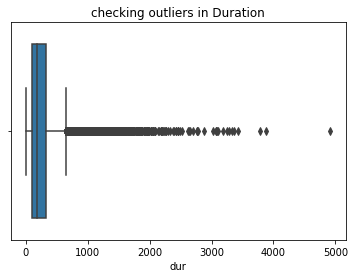

In [ ]:
#checking outliers in duration column
sns.boxplot('dur',data=cus_df)
plt.title("checking outliers in Duration")

In [ ]:
cus_df.dur.describe()

count    44917.000000
mean       258.314959
std        257.724537
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: dur, dtype: float64

There are many outliers, so going to clipping the outliers 

In [ ]:
clip_outliers(cus_df,'dur')

Text(0.5, 1.0, 'checking outliers in Duration after clipping')

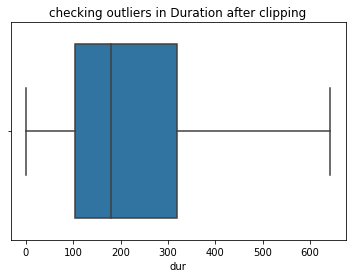

In [ ]:
#checking outliers in duration column after clipping outliers
sns.boxplot('dur',data=cus_df)
plt.title("checking outliers in Duration after clipping")

**Number_calls** -- Column

In [ ]:
#checking the null Values
cus_df['num_calls'].isnull().sum()

0

In [ ]:
#Checking unique values
cus_df['num_calls'].unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44])

In [ ]:
#Statistical information of num_calls
cus_df.num_calls.describe()

count    44917.000000
mean         2.760403
std          3.093007
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: num_calls, dtype: float64

From the above data 75% of data have below 3 number of calls. Above 30 number of calls are not possible in real world seen to be those are outliers

In [ ]:
#detecting outliers of num_calls column
detect_outliers(cus_df, 'num_calls')

LowerFence: -2.0, UpperFence: 6.0
3031 Outliers present in num_calls


Text(0.5, 1.0, 'checking outliers in Number of calls')

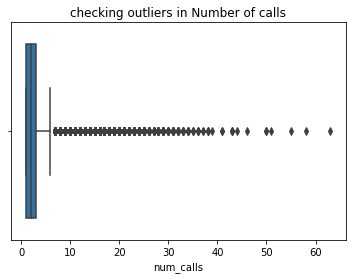

In [ ]:
#checking outliers in day column
sns.boxplot('num_calls',data=cus_df)
plt.title("checking outliers in Number of calls")

In [ ]:
#clipping outliers
clip_outliers(cus_df,'num_calls')

Text(0.5, 1.0, 'checking outliers in Number of calls  after clipping')

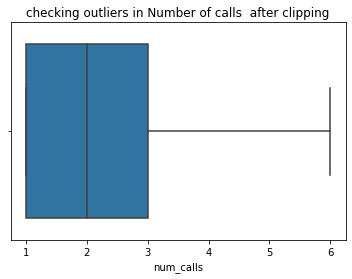

In [ ]:
#checking outliers in Number of calls column after clipping outliers
sns.boxplot('num_calls',data=cus_df)
plt.title("checking outliers in Number of calls  after clipping")

**Prev_outcome** -- Column

In [ ]:
#checking the null Values
cus_df['prev_outcome'].isnull().sum()

0

In [ ]:
#checking the unique values and their counts
cus_df['prev_outcome'].value_counts()

unknown    36698
failure     4881
other       1838
success     1500
Name: prev_outcome, dtype: int64

In [ ]:
print("The percentage of unknown data is:", ((cus_df['prev_outcome']=='unknown').sum()/cus_df.shape[0])*100)

The percentage of unknown data is: 81.70180555246344


In [ ]:
cus_df['target'] = cus_df['y'].map({"yes":1,"no":0})

In [ ]:
cus_df.groupby('prev_outcome')['target'].mean()

prev_outcome
failure    0.125384
other      0.166485
success    0.646000
unknown    0.091776
Name: target, dtype: float64

**whenver `previous outcome is success` there is a 64% chance of customers bought the insurance **

In [ ]:
#column list after droping prev_outcome column
cus_df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y', 'target'],
      dtype='object')

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
cus_df_yes = cus_df[cus_df['y'] == 'yes']
cus_df_no = cus_df[cus_df['y'] == 'no']

In [ ]:
#function to visualize the categorical columns
def feature_vs_target(dataframe, feature, target):
  
  plt.figure(figsize=(16,6))
  
  plt.subplot(121)
  sns.set_theme(style="darkgrid",palette="bright")
  sns.countplot(x=feature, hue=target, data=cus_df, order=cus_df[feature].value_counts().index)
  plt.title(feature + " vs " + target,fontsize = 20)
  plt.xticks(rotation=60)
  
  plt.subplot(122)  
  sns.countplot(x=feature, data=cus_df_yes, order=cus_df_yes[feature].value_counts().index)
  plt.title(feature + " vs who take insurance",fontsize = 20)
  plt.xticks(rotation=60)
  plt.tight_layout()
  plt.show()

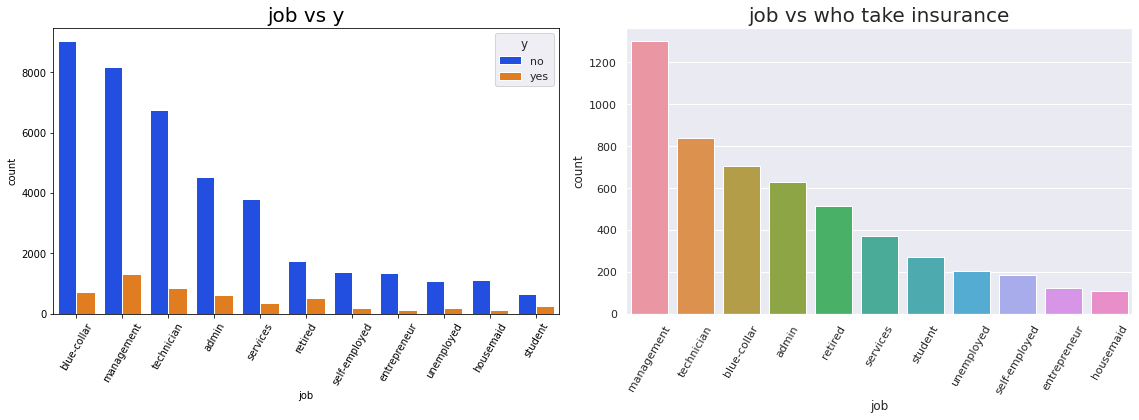

In [ ]:
#visualization for Job column
feature_vs_target(cus_df,'job','y')

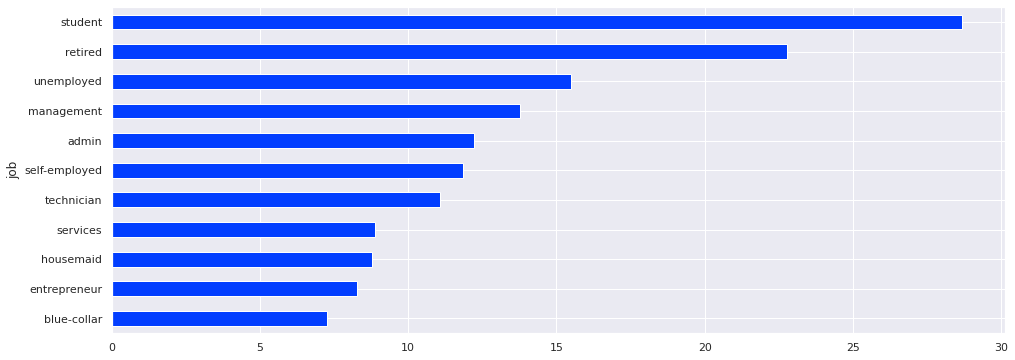

In [ ]:
plt.figure(figsize=(16,6))
(cus_df.groupby('job')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

**Interpretation of Job plots** 
1. Management people takes insurance compared to other professions
2. Conversion rate is higher in students and retired category is better comapred to other category.Targetting those kind of category people helps to get more subscription

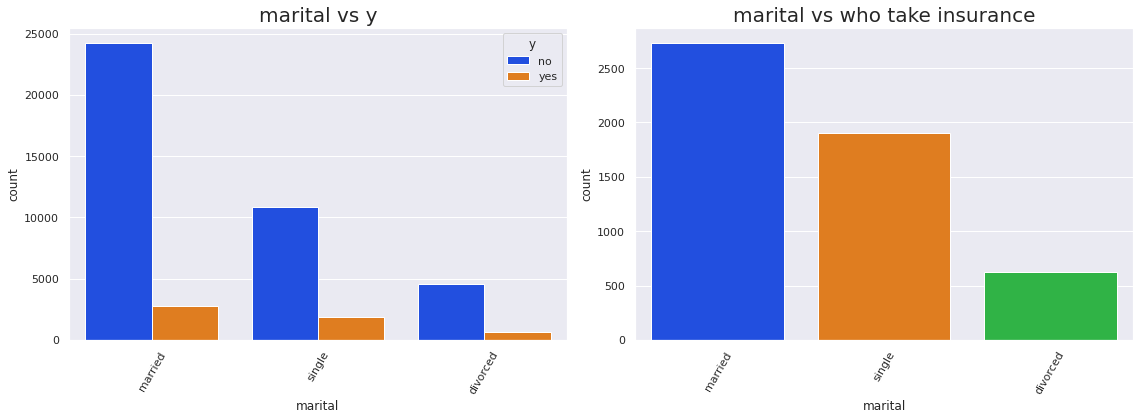

In [ ]:
#visualization for Marital column
feature_vs_target(cus_df,'marital','y')

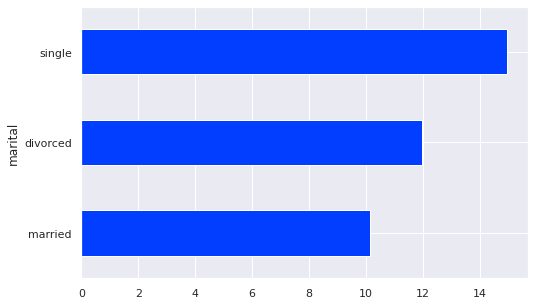

In [ ]:
plt.figure(figsize=(8,5))
(cus_df.groupby('marital')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

**Interpretation of Marital plot** 
1. Married people taking insurance compared to single and divorced persons but the conversion rate is higher in single people(Reason-people in younger age purchase insurance may be because of low premium)compared to married and divorced people


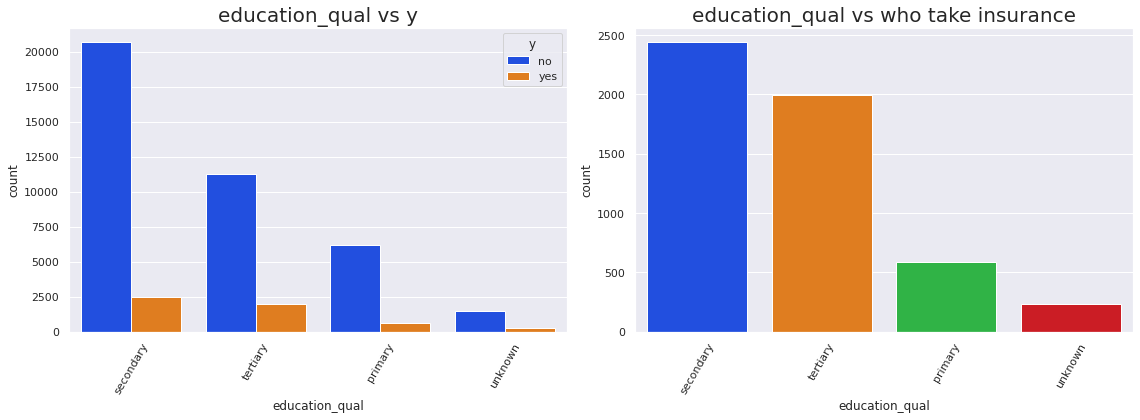

In [ ]:
#visualization for Education Qualification column
feature_vs_target(cus_df,'education_qual','y')

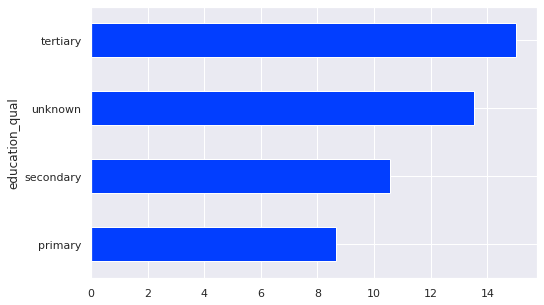

In [ ]:
plt.figure(figsize=(8,5))
(cus_df.groupby('education_qual')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

**Interpretation of Eduation Qualification plot** 

1. People who undergone seconday and tertiary education ie.12th class and above (college) have knowledge about insurance subscribed more 

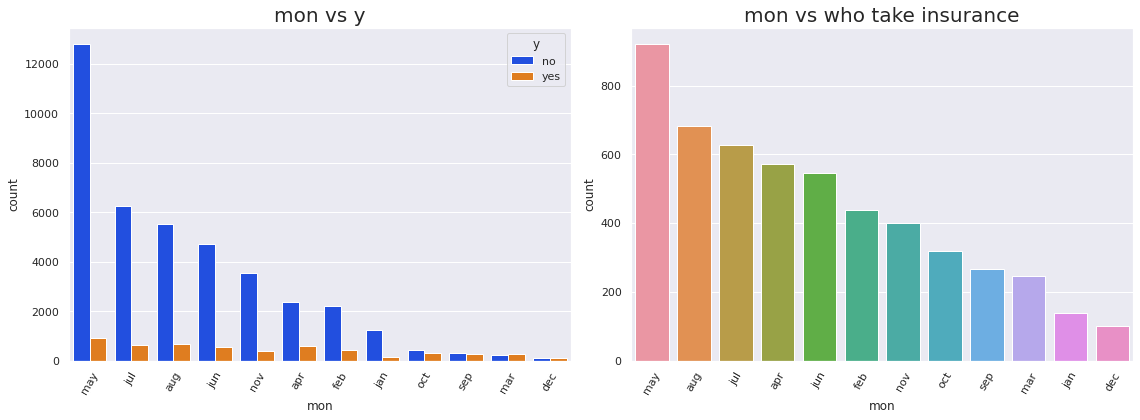

In [ ]:
#visualization for Month column
feature_vs_target(cus_df,'mon','y')

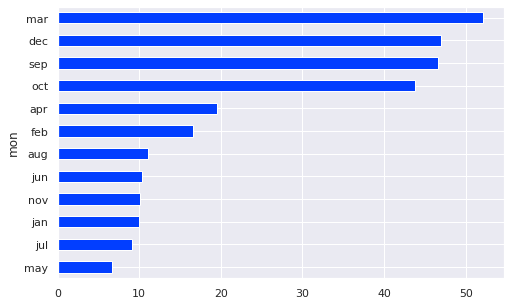

In [ ]:
plt.figure(figsize=(8,5))
(cus_df.groupby('mon')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

**Interpretation of Month plot** 
1. people take more insurance in the month of may but conversion rate of march, december and september is high which is around 50%


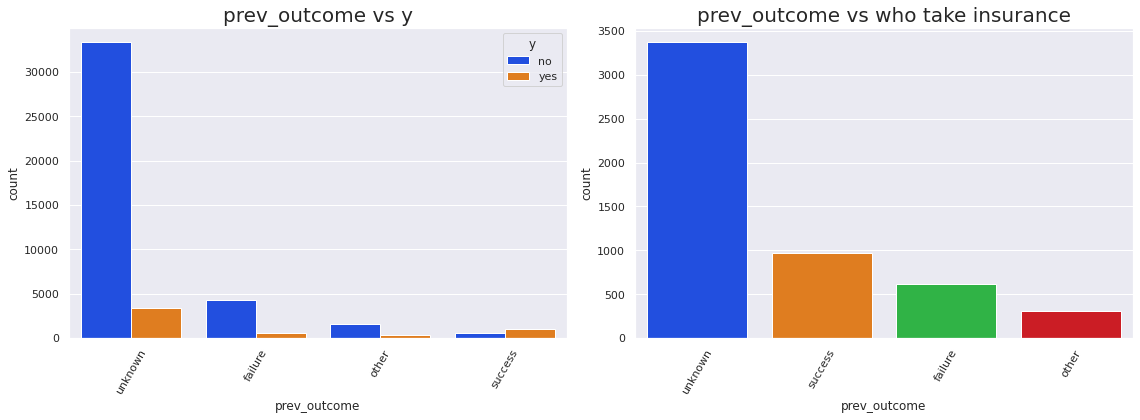

In [ ]:
#visualization for previous outcome column
feature_vs_target(cus_df,'prev_outcome','y')

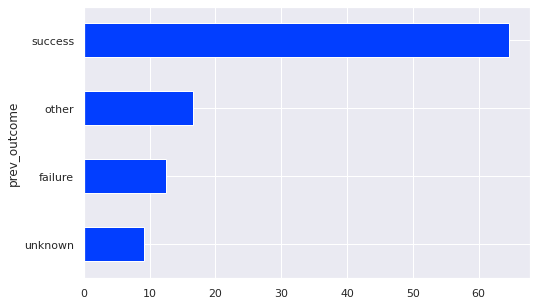

In [ ]:
plt.figure(figsize=(8,5))
(cus_df.groupby('prev_outcome')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()



*   If the previous outcome is success then that person is more likely to purchase insurance beacuse the conversion rate is above 60% 




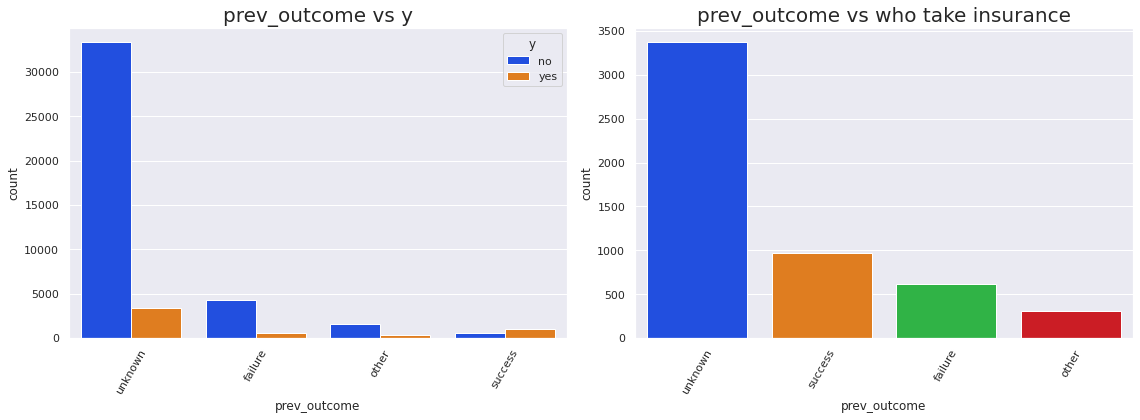

In [ ]:
#visualization for call type column
feature_vs_target(cus_df,'prev_outcome','y')

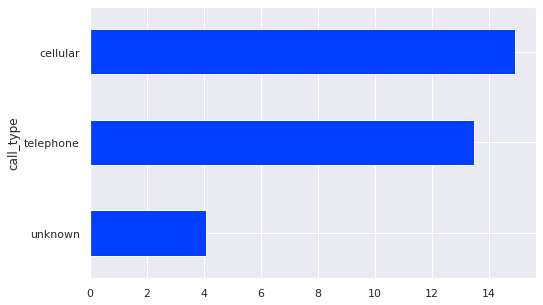

In [ ]:
plt.figure(figsize=(8,5))
(cus_df.groupby('call_type')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

Text(0, 0.5, 'Count')

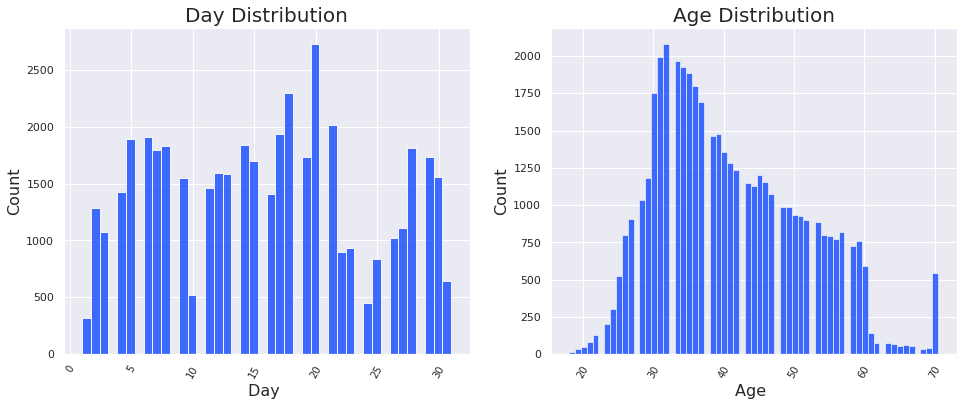

In [ ]:
#Visualization of Numerical Columns
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(cus_df['day']) 
sns.set_theme(style="darkgrid",palette="bright")
plt.title('Day Distribution', fontsize = 20) 
plt.xlabel('Day ',fontsize = 16) 
plt.xticks(rotation = 60,fontsize = 10) 
plt.ylabel('Count',fontsize = 16)

plt.subplot(1,2,2)
sns.histplot(cus_df['age']) 
sns.set_theme(style="darkgrid",palette="bright")
plt.title('Age Distribution', fontsize = 20) 
plt.xlabel('Age ',fontsize = 16) 
plt.xticks(rotation = 60,fontsize = 10) 
plt.ylabel('Count',fontsize = 16)

Text(0.5, 1.0, 'Day vs Target(y)')

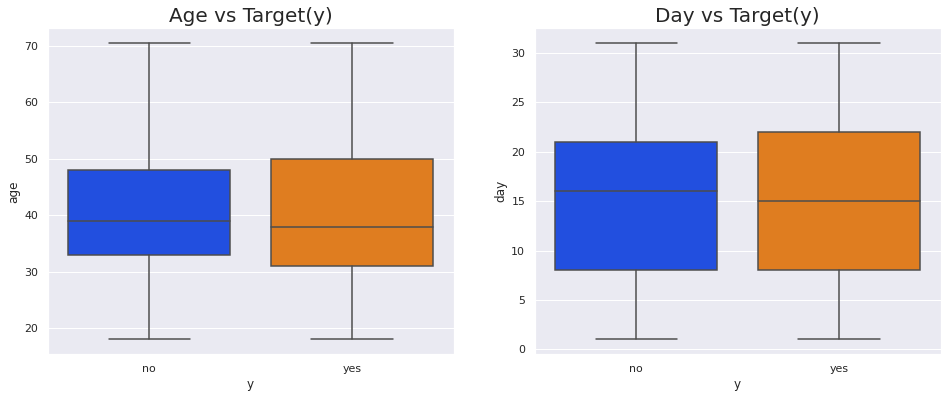

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(data = cus_df,x='y',y='age')
plt.title('Age vs Target(y)', fontsize = 20) 
plt.subplot(1,2,2)
sns.boxplot(data = cus_df,x='y',y='day')
plt.title('Day vs Target(y)', fontsize = 20) 

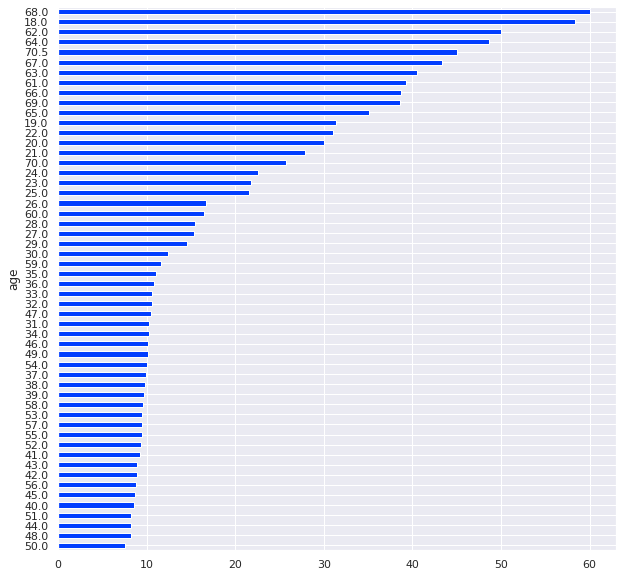

In [ ]:
plt.figure(figsize=(10,10))
(cus_df.groupby('age')['target'].mean()*100).sort_values().plot(kind = 'barh')
plt.show()

**Interpretation of Age plot**  - People who are in age above 60 have conversion rate of 50% and people in 20's also interested in   taking insurance

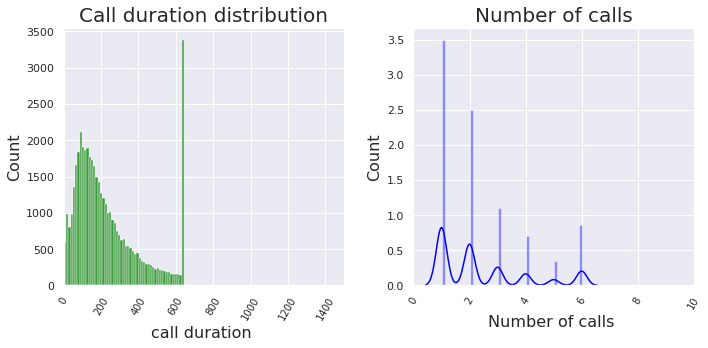

In [ ]:
#visualizing the Call distribution and number of calls
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.set_theme(style="darkgrid",palette="bright")
sns.histplot(cus_df['dur'],color = 'green')
plt.title('Call duration distribution', fontsize = 20) 
plt.xlabel('call duration ',fontsize = 16) 
plt.xticks(rotation = 60,fontsize = 10) 
plt.xlim([0,1500])
plt.ylabel('Count',fontsize = 16)

plt.subplot(1,2,2)

sns.distplot(cus_df['num_calls'],color = 'blue')
plt.title('Number of calls', fontsize = 20) 
plt.xlabel('Number of calls ',fontsize = 16) 
plt.xticks(rotation = 60,fontsize = 10) 
plt.xlim([0,10])
plt.ylabel('Count',fontsize = 16)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Day vs Target(y)')

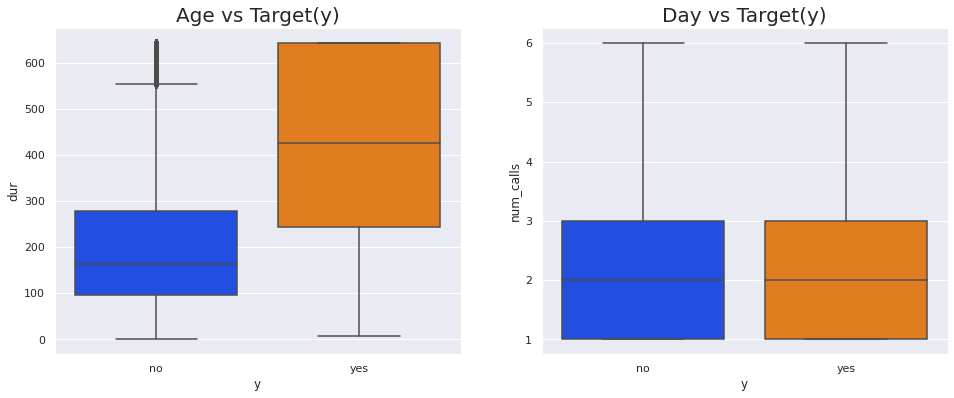

In [ ]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.boxplot(data = cus_df,x='y',y='dur')
plt.title('Age vs Target(y)', fontsize = 20) 
plt.subplot(1,2,2)
sns.boxplot(data = cus_df,x='y',y='num_calls')
plt.title('Day vs Target(y)', fontsize = 20) 

**Interpretation of call duration plot**  - More the duration more purchase of insurance.It is easy to convience if we talk to customer more

In [ ]:
cus_df.to_csv('customer_conversion_final.csv')

# **Label Encodeing**

Encoded in the order category have higher convesrion rate

In [ ]:
cus_df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y', 'target'],
      dtype='object')

In [ ]:
cus_df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

In [ ]:
#job column
cus_df.job = cus_df.job.map({'student':10,
                             'retired': 9,
                             'unemployed': 8,
                             'management': 7,
                             'admin': 6, 
                             'self-employed': 5, 
                             'technician': 4,
                             'services': 3,
                             'housemaid': 2,
                             'entrepreneur': 1, 
                             'blue-collar': 0})

In [ ]:
#month column
cus_df.mon = cus_df.mon.map({'mar': 11, 
                             'dec': 10,
                             'sep': 9,
                             'oct': 8,
                             'apr': 7,
                             'feb': 6,
                             'aug': 5,
                             'jun': 4,
                             'nov': 3,
                             'jan': 2,                                                       
                             'jul': 1,                             
                             'may':0})

In [ ]:
#target column
cus_df.y = cus_df.y.map({'yes':1, 'no':0})

In [ ]:
#call type column
cus_df.call_type =cus_df.call_type.map({'cellular':2,
                                        'telephone':1,
                                        'unknown':0})

In [ ]:
#marital column
cus_df.marital =cus_df.marital.map({'single':2,
                                    'divorced':1,
                                    'married':0})

In [ ]:
#education qualification
cus_df.education_qual =cus_df.education_qual.map({'tertiary':3,
                                                  'unknown':2,
                                                  'secondary':1,
                                                  'primary':0})

In [ ]:
#previous outcome column
cus_df.prev_outcome =cus_df.prev_outcome.map({'success':3,
                                              'other':2,
                                              'failure':1,
                                              'unknown':0})

In [ ]:
cus_df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y', 'target'],
      dtype='object')

In [ ]:
cus_df['marital'].unique()

array([0, 2, 1])

In [ ]:
cus_df['prev_outcome'].unique()

array([0, 1, 2, 3])

# **Model Building**

**Data Splitting and Scaling**

In [ ]:
X = cus_df[['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon','dur', 'num_calls','prev_outcome']].values

In [ ]:
o_feature =cus_df[['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls','prev_outcome']]

In [ ]:
y = cus_df[['y']].values

In [ ]:
print('Independent feature X has {} rows and {} columns'.format(X.shape[0],X.shape[1]))
print('Dependent feature y has {} rows and {} columns'.format(y.shape[0],y.shape[1]))

Independent feature X has 44917 rows and 10 columns
Dependent feature y has 44917 rows and 1 columns


**Splitting the data**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print("The shape of X train:", X_train.shape)
print("The shape of X test:", X_test.shape)
print("The shape of y train:", y_train.shape)
print("The shape of y test:", y_test.shape)

The shape of X train: (35933, 10)
The shape of X test: (8984, 10)
The shape of y train: (35933, 1)
The shape of y test: (8984, 1)


**Scaling the data**

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
scaler.fit(X_train,y_train) 
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [ ]:
cus_df.isnull().sum()

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
target            0
dtype: int64

**Balancing the target column**

In [ ]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Over sampling followed by under sampling**

In [ ]:
from imblearn.combine import SMOTEENN
smt = SMOTEENN(sampling_strategy='all')
X_smt, y_smt = smt.fit_resample(X_train_scaled, y_train)

In [ ]:
y_smt.shape

(56161,)

**Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_smt,y_smt)


LogisticRegression()

In [ ]:
lr_y_pred = lr.predict(X_test_scaled)
lr_y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import roc_auc_score
log = roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1])
print("The AUROC Score of Logistic Regression model",log)

The AUROC Score of Logistic Regression model 0.8987364633832731


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, f1_score, recall_score, classification_report, roc_curve, roc_auc_score

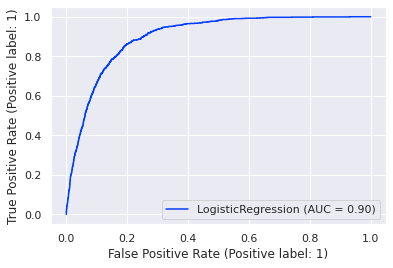

In [ ]:
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(lr, X_test_scaled, y_test)

In [ ]:
#accuracy score for logistic Regression
accuracy_score(y_test,lr_y_pred) #accuracy

0.7875111308993766

In [ ]:
print(confusion_matrix(y_test, lr_y_pred))
print(classification_report(y_test,lr_y_pred))

[[6140 1784]
 [ 125  935]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.87      7924
           1       0.34      0.88      0.49      1060

    accuracy                           0.79      8984
   macro avg       0.66      0.83      0.68      8984
weighted avg       0.90      0.79      0.82      8984



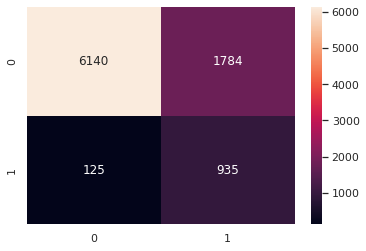

In [ ]:
#visualizing confusion matrix
cm = confusion_matrix(y_test, lr_y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

**KNN Algorithm**

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
for i in [1,2,3,4,5,6,7,8,9,10,20]:
  knn = KNeighborsClassifier(i)
  knn.fit(X_smt, y_smt) 
  print("K value  : " , i, " train score : ",knn.score(X_train_scaled, y_train) , " cv score : ", np.mean(cross_val_score(knn, X_train, y_train, cv=10, scoring = "roc_auc"))) 
  

K value  :  1  train score :  0.8816408315476025  cv score :  0.640019813223913
K value  :  2  train score :  0.889460941196115  cv score :  0.7079152711505212
K value  :  3  train score :  0.8587649236078256  cv score :  0.7475176818015279
K value  :  4  train score :  0.8649987476692733  cv score :  0.7694288996421963
K value  :  5  train score :  0.8461581276264158  cv score :  0.7874568150440139
K value  :  6  train score :  0.8528650544068127  cv score :  0.7995712922931729
K value  :  7  train score :  0.8352489355188824  cv score :  0.8100041604744229
K value  :  8  train score :  0.8423454763031197  cv score :  0.8171455063588506
K value  :  9  train score :  0.8281245651629422  cv score :  0.8225366145751684
K value  :  10  train score :  0.8351097876603679  cv score :  0.8269666580275368
K value  :  20  train score :  0.8166587816213509  cv score :  0.8506336140829944


In [ ]:
knn_dict = {'K value':[],'train score':[],'cv score':[]}
for i in [1,2,3,4,5,6,7,8,9,10,20]:
  knn = KNeighborsClassifier(i)
  knn.fit(X_smt, y_smt)
  knn_dict['K value'].append(i)
  knn_dict['train score'].append(knn.score(X_train_scaled, y_train))
  knn_dict['cv score'].append(np.mean(cross_val_score(knn, X_train, y_train, cv=10, scoring = "roc_auc")))

pd.DataFrame(knn_dict)

,K value,train score,cv score
0,1,0.881641,0.640020
1,2,0.889461,0.707915
2,3,0.858765,0.747518
3,4,0.864999,0.769429
4,5,0.846158,0.787457
5,6,0.852865,0.799571
6,7,0.835249,0.810004
7,8,0.842345,0.817146
8,9,0.828125,0.822537
9,10,0.835110,0.826967


In [ ]:
#fiiting the model
knn = KNeighborsClassifier(10) #k-value = 10
knn.fit(X_smt,y_smt)


KNeighborsClassifier(n_neighbors=10)

In [ ]:
knn_y_pred=knn.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import roc_auc_score
knn_log = roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1])
print("The AUROC Score of K-Nearest-Neighbour model",knn_log)

The AUROC Score of K-Nearest-Neighbour model 0.88163526377949


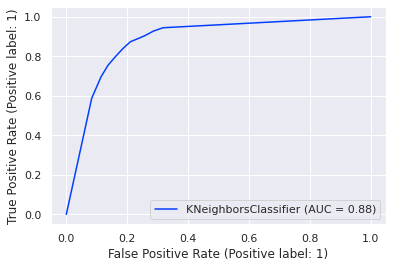

In [ ]:
#plotting ROC Curve
RocCurveDisplay.from_estimator(knn, X_test_scaled, y_test)

In [ ]:
print(classification_report(y_test,knn_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.81      0.89      7924
           1       0.38      0.84      0.52      1060

    accuracy                           0.82      8984
   macro avg       0.68      0.83      0.70      8984
weighted avg       0.90      0.82      0.84      8984



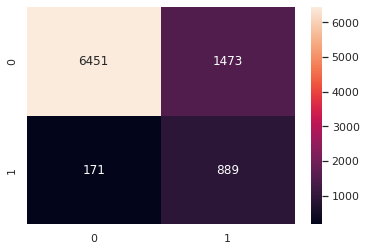

In [ ]:
#visualizing confusion matrix
cm = confusion_matrix(y_test, knn_y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

**Decision Tree**

In [ ]:
for depth in [1,2,3,4,5,6,7,8,9,10,20]:
  dt = DecisionTreeClassifier(max_depth=depth) 
  dt.fit(X_smt, y_smt) 
  trainAccuracy = accuracy_score(y_train, dt.predict(X_train_scaled)) 
  dt = DecisionTreeClassifier(max_depth=depth) 
  valAccuracy = cross_val_score(dt, X_train_scaled, y_train, cv=10) 
  print("Depth  : ", depth, " Training Accuracy : ", trainAccuracy, " Cross val score : " ,np.mean(valAccuracy))

Depth  :  1  Training Accuracy :  0.6418890713271923  Cross val score :  0.8832549564238013
Depth  :  2  Training Accuracy :  0.5789107505635488  Cross val score :  0.8904626042011758
Depth  :  3  Training Accuracy :  0.6958227812873959  Cross val score :  0.8968079046299916
Depth  :  4  Training Accuracy :  0.7125483538808338  Cross val score :  0.8991174718169148
Depth  :  5  Training Accuracy :  0.8090334789747585  Cross val score :  0.8992287839103457
Depth  :  6  Training Accuracy :  0.7582723401886845  Cross val score :  0.8993124886840966
Depth  :  7  Training Accuracy :  0.7889961873486767  Cross val score :  0.8983105017314784
Depth  :  8  Training Accuracy :  0.8222803551053349  Cross val score :  0.8972252126925214
Depth  :  9  Training Accuracy :  0.8302674421840648  Cross val score :  0.896195324148653
Depth  :  10  Training Accuracy :  0.8289872818857318  Cross val score :  0.8938578631144681
Depth  :  20  Training Accuracy :  0.9096095511090084  Cross val score :  0.8766

In [ ]:
dt_dict = {'depth':[],'train score':[],'cv score':[]}
for depth in [1,2,3,4,5,6,7,8,9,10,20]:
  dt = DecisionTreeClassifier(max_depth=depth) 
  dt.fit(X_smt, y_smt) 
  dt_dict['depth'].append(depth)
  dt_dict['train score'].append(accuracy_score(y_train, dt.predict(X_train_scaled)))
  dt_dict['cv score'].append(np.mean(cross_val_score(dt, X_train_scaled, y_train, cv=10)))

pd.DataFrame(dt_dict)

,depth,train score,cv score
0,1,0.641889,0.883255
1,2,0.578911,0.890463
2,3,0.695823,0.896808
3,4,0.712548,0.899117
4,5,0.809033,0.899229
5,6,0.758272,0.899285
6,7,0.788968,0.898338
7,8,0.822169,0.897253
8,9,0.830407,0.896168
9,10,0.828820,0.894331


In [ ]:
#fitting the model
dt = DecisionTreeClassifier(max_depth=7) 
dt.fit(X_smt, y_smt)


DecisionTreeClassifier(max_depth=7)

In [ ]:
dt_y_pred = dt.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import roc_auc_score
dt_log = roc_auc_score(y_test, dt.predict_proba(X_test_scaled)[:, 1])
print("The AUROC Score of Decision tree Classifier model",dt_log)

The AUROC Score of Decision tree Classifier model 0.891495325878868


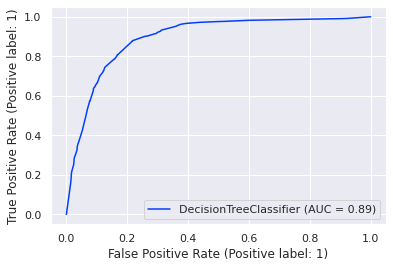

In [ ]:
#plotting ROC Curve
RocCurveDisplay.from_estimator(dt, X_test_scaled, y_test)

In [ ]:
print(classification_report(y_test,dt_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      7924
           1       0.35      0.88      0.50      1060

    accuracy                           0.79      8984
   macro avg       0.67      0.83      0.69      8984
weighted avg       0.91      0.79      0.83      8984



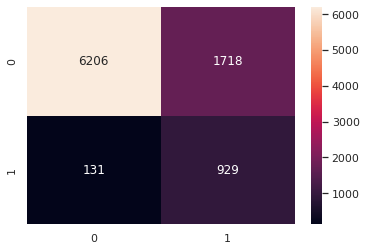

In [ ]:
#visualizing confusion matrix
cm = confusion_matrix(y_test, dt_y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

**Random Forest classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators= 100, max_depth = 7, max_features='sqrt')
rf.fit(X_smt,y_smt)

RandomForestClassifier(max_depth=7)

In [ ]:
rf_y_pred = rf.predict(X_test_scaled)
rf_y_pred

array([0, 1, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import roc_auc_score
rf_log = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])
print("The AUROC Score of Random Forest classifier model",dt_log)

The AUROC Score of Random Forest classifier model 0.9191768141685637


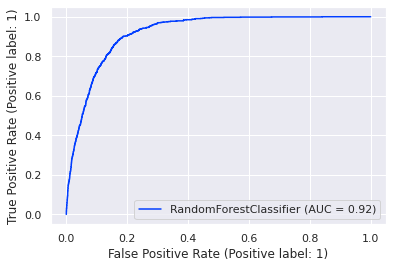

In [ ]:
#plotting ROC Curve
RocCurveDisplay.from_estimator(rf, X_test_scaled, y_test)

In [ ]:
print(classification_report(y_test,rf_y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7924
           1       0.40      0.89      0.55      1060

    accuracy                           0.83      8984
   macro avg       0.69      0.86      0.72      8984
weighted avg       0.91      0.83      0.85      8984



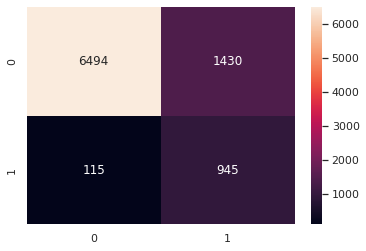

In [ ]:
#visualizing confusion matrix
cm = confusion_matrix(y_test, rf_y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

**XG Boost**

In [ ]:
import xgboost as xgb
for lr in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
  model = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
  model.fit(X_smt,y_smt) #train the model
  print("Learning rate : ", lr, " Train score : ", model.score(X_train_scaled,y_train), " Cross-Val score : ", np.mean(cross_val_score(model, X_train_scaled, y_train, cv=10)))

Learning rate :  0.01  Train score :  0.8172153730554087  Cross-Val score :  0.9007872461462428
Learning rate :  0.02  Train score :  0.8219464002449002  Cross-Val score :  0.9017612618117123
Learning rate :  0.03  Train score :  0.8275123145854786  Cross-Val score :  0.9019560773351882
Learning rate :  0.04  Train score :  0.8360559930982662  Cross-Val score :  0.9030692602214069
Learning rate :  0.05  Train score :  0.84485013775638  Cross-Val score :  0.9027631558364663
Learning rate :  0.06  Train score :  0.849970778949712  Cross-Val score :  0.9032919386161895
Learning rate :  0.07  Train score :  0.8566498761584059  Cross-Val score :  0.9037372334538454
Learning rate :  0.08  Train score :  0.8624105975009044  Cross-Val score :  0.9040711697341381
Learning rate :  0.09  Train score :  0.868700080705758  Cross-Val score :  0.9041546963961491
Learning rate :  0.1  Train score :  0.871761333593076  Cross-Val score :  0.9042103834188191
Learning rate :  0.11  Train score :  0.874766

In [ ]:
xg_dict = {'Learning rate':[],'train score':[],'cv score':[]}
for lr in [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.2,0.5,0.7,1]:
  model = xgb.XGBClassifier(learning_rate = lr, n_estimators=100, verbosity = 0) # initialise the model
  model.fit(X_smt,y_smt) #train the model
  xg_dict['Learning rate'].append(lr)
  xg_dict['train score'].append(model.score(X_train_scaled,y_train))
  xg_dict['cv score'].append(np.mean(cross_val_score(model, X_train_scaled, y_train, cv=10)))

pd.DataFrame(xg_dict)

,Learning rate,train score,cv score
0,0.01,0.817215,0.900787
1,0.02,0.821946,0.901761
2,0.03,0.827512,0.901956
3,0.04,0.836056,0.903069
4,0.05,0.844850,0.902763
5,0.06,0.849971,0.903292
6,0.07,0.856650,0.903737
7,0.08,0.862411,0.904071
8,0.09,0.868700,0.904155
9,0.10,0.871761,0.904210


In [ ]:
#fitting the model
xg_model = xgb.XGBClassifier(learning_rate = 0.5, n_estimators=100)
xg_model.fit(X_smt,y_smt)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
xg_y_pred = xg_model.predict(X_test_scaled)
xg_y_pred

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import roc_auc_score
xg_log = roc_auc_score(y_test, xg_model.predict_proba(X_test_scaled)[:, 1])
print("The AUROC Score of XG boost model",xg_log)

The AUROC Score of XG boost model 0.9310361762212719


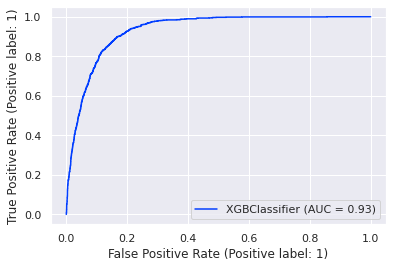

In [ ]:
#plotting ROC Curve
RocCurveDisplay.from_estimator(xg_model, X_test_scaled, y_test)

In [ ]:
print(classification_report(y_test,xg_y_pred))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7924
           1       0.50      0.78      0.61      1060

    accuracy                           0.88      8984
   macro avg       0.73      0.84      0.77      8984
weighted avg       0.91      0.88      0.89      8984



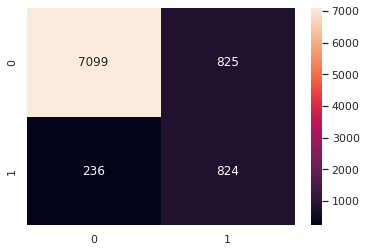

In [ ]:
#visualizing confusion matrix
cm = confusion_matrix(y_test,xg_y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

# Feature Importances

In [ ]:
importances = list(rf.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(o_feature.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_imp_dict = {'features':[],'importance':[]}
for pair,value in feature_importances:
  feature_imp_dict['features'].append(pair)
  feature_imp_dict['importance'].append(value)
feature_imp_df = pd.DataFrame(feature_imp_dict)
feature_imp_df = feature_imp_df.loc[0:6]
  
  

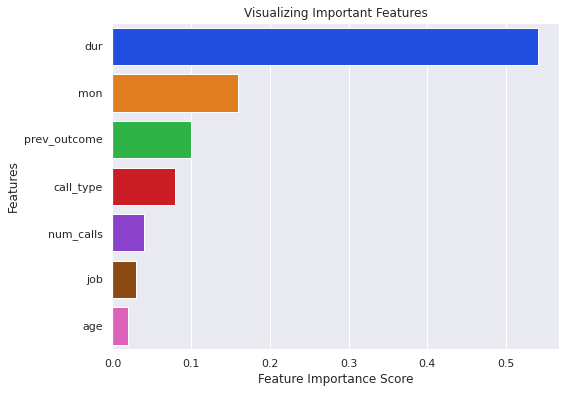

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(y=feature_imp_df['features'], x=feature_imp_df['importance'],orient='horizonal', ax=ax)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

# Saving the Model

In [ ]:
import pickle


In [ ]:

import pickle
filename = "XGB_model"
pickle.dump(xg_model, open(filename, "wb"))#getting Good AUROC score in Xg Boost Model-Saving that model for deployment

In [ ]:
import pickle
filename = "Xgb_model"
pickle.dump(rf, open(filename, "wb"))